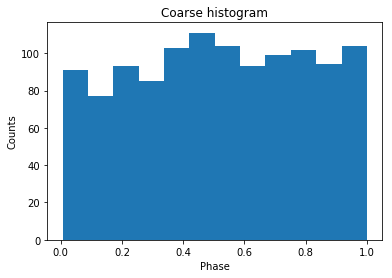

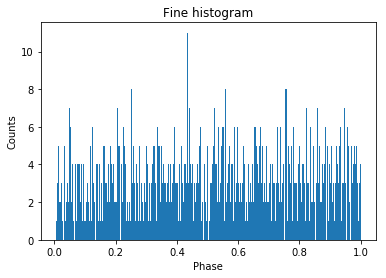

In [1]:
from numpy import *
from pandas import read_csv
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from pylab import *
from scipy import special

sheet2 = read_csv('Birthdays - Sheet2.csv')
phase, total = sheet2['Phase'].values[:-1], sheet2['Total'].values[:-1]

phases_all = list()
for i in range(365):
    for j in range(total[i]): phases_all.append(phase[i])
phases_all = np.array(phases_all)

# Plot histograms
plt.hist(phases_all, 12)
plt.title("Coarse histogram")
plt.xlabel("Phase")
plt.ylabel("Counts")
plt.figure()
plt.hist(phases_all,365)
plt.title("Fine histogram")
plt.xlabel("Phase")
plt.ylabel("Counts")
plt.show()

The coarse histogram with monthly bins appears to show that the number of birthdays peak slightly in June, and that there are slightly more birthdays on the second half of the year than on the first half. The fine histogram with daily bins shows that one particular day close to the middle of the year has a significantly larger number of birthday occurrences than most other days. There does not appear to be an obvious pattern in the rest of the histogram.

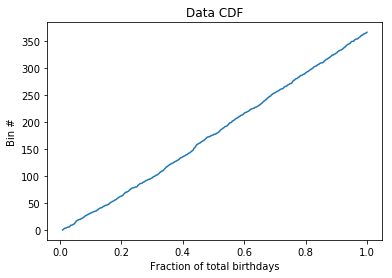

In [27]:
# Plot data CDF
counts, bin_edges = histogram(phases_all, bins=365, normed=True)
cdf = cumsum(counts)
plt.plot(bin_edges[1:], cdf)
plt.title("Data CDF")
plt.ylabel("Bin #")
plt.xlabel("Fraction of total birthdays")
plt.show()

The CDF appears to be a simple straight line, which suggests that the PDF should be very close to that of a flat distribution.

Location and maximum value of likelihood: [0.081632653144897954, 0.32653061224489793, 1.9923674823141866]
Location and maximum value of Posterior PDF: [0.010204081730612245, 0.32653061224489793, 1.9349403989727949]
Global likelihood = 1053.34093657


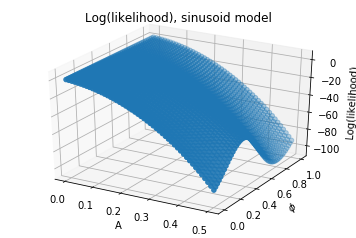

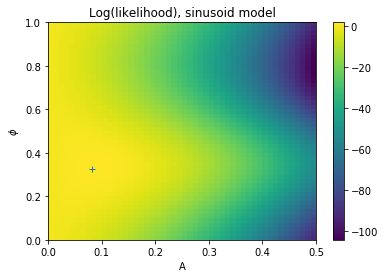

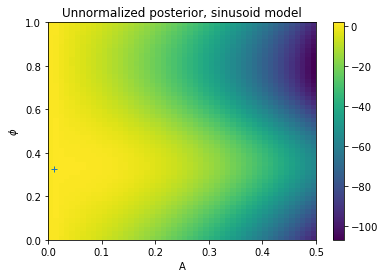

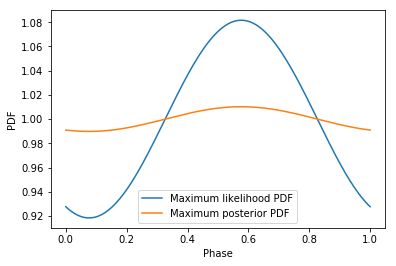

In [2]:
# Model PDF 1

def sinemodel(phi, A, offset):
    # Sinusoid model, dependent on two parameters A (amplitude) and offset (phase). Amplitude cannot exceed 1.
    return A*sin(2.*pi*(phi-offset))+1

Amin = 1.e-10
Amax = 0.5
size = 50
Avec = linspace(Amin,Amax,size)
offvec = linspace(0.,1.,size)

# Define priors. Used a Jeffrey's prior for A, flat prior for offset
priorA = zeros(len(Avec))
priorA[1:] = 1./(Avec[1:]*log(Amax/Amin))
priorA[0] = priorA[1]
prioros = ones(len(offvec))/max(offvec)

# Calculate log(priors)
papbvec = []
for pa in priorA:
    for pb in prioros:
        papbvec.append(log(pa)+log(pb))

# Calculate log(likelihood)
Aos = []
for A in Avec:
    for os in offvec:
        Aos.append([A,os])

Avec = []
osvec = []
likelihood = []
for nAos in Aos:
    A = nAos[0]
    os = nAos[1]
    probabilities = []
    for phi in phases_all:
        prob = sinemodel(phi, A, os)
        probabilities.append(prob)
    likepoint = sum(log(asarray(probabilities)))
    likelihood.append(likepoint)
    osvec.append(os)
    Avec.append(A)

Avec = asarray(Avec)
osvec = asarray(osvec)
likelihood = asarray(likelihood)
m = likelihood.argmax()
best = [Avec[m], osvec[m], likelihood[m]] # maximum likelihood
print("Location and maximum value of likelihood: " + str(best))
extent = (Avec.min(), Avec.max(), osvec.min(), osvec.max())

# Log(likelihood) plots
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(Avec,osvec,likelihood)
ax.set_xlabel("A")
ax.set_ylabel(r'$\phi$')
ax.set_zlabel("Log(likelihood)")
ax.set_title("Log(likelihood), sinusoid model")

likelihood2 = asarray(likelihood).reshape(size,size)
plt.figure()
plt.imshow(likelihood2.T, aspect='auto', origin='lower', extent=extent)
plt.colorbar()
plt.xlabel("A")
plt.ylabel(r'$\phi$')
plt.plot(Avec[m],osvec[m], '+')
plt.title("Log(likelihood), sinusoid model")

# Unnormalized posterior plot
posterior = asarray(papbvec + likelihood)
mp = posterior.argmax()
bestp = [Avec[mp], osvec[mp], posterior[mp]]
print("Location and maximum value of Posterior PDF: " + str(bestp))
plt.figure()
plt.imshow(posterior.reshape(size,size).T, aspect='auto', origin='lower', extent=extent)
plt.plot(Avec[mp],osvec[mp], '+')
plt.colorbar()
plt.xlabel("A")
plt.ylabel(r'$\phi$')
plt.title("Unnormalized posterior, sinusoid model")

# Find global likelihood
glikelihood1 = 0
for l in posterior:
    glikelihood1 = glikelihood1 + exp(l)
print("Global likelihood = " + str(glikelihood1))

# Plot PDF with maximum likelihood and maximum posterior parameters
xvec = linspace(0,1,1000)
A1, A2 = best[0], bestp[0]
os1, os2 = best[1], bestp[1]
lsine = []
psine = []
for x in xvec:
    lsine.append(sinemodel(x,A1,os1))
    psine.append(sinemodel(x,A2,os2))
plt.figure()
plt.plot(xvec, lsine, label = "Maximum likelihood PDF")
plt.plot(xvec, psine, label = "Maximum posterior PDF")
plt.xlabel("Phase")
plt.ylabel("PDF")
plt.legend()
plt.show()

The resulting PDF under this model is close to flat whether one uses the maximum likelihood parameters or the maximum posterior parameters, but the use of the Jeffrey's prior for the amplitude parameter causes a significant discrepancy between the amplitude found using the maximum likelihood and the one where the maximum posterior PDF is located. The offset, on the other hand, appears to be almost identical in both cases.

Location and maximum value of likelihood: [1.0816326530612246, 1.0, 3.6043037913096185]
Location and maximum value of Posterior PDF: [1.0816326530612246, 1.0, 2.495590569772407]
Global likelihood = 13.0209727723


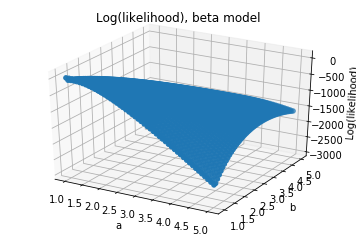

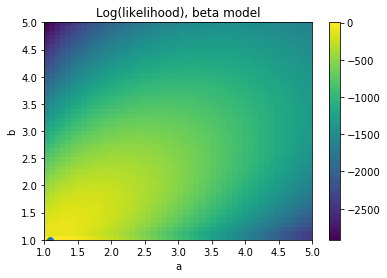

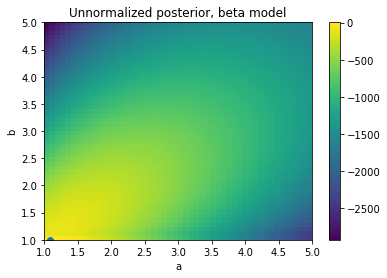

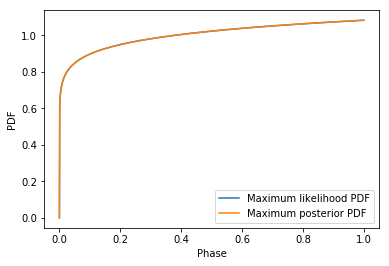

In [7]:
# Model PDF #2

def betamodel(x,a,b):
    # Beta distribution model, convenient since it is normalized between 0 and 1 for all values of parameters
    # a and b >= 1
    return special.gamma(a+b)/(special.gamma(a)*special.gamma(b)) * x**(a-1) * (1-x)**(b-1)

amin = 1
amax = 5
size = 50
avec = linspace(amin,amax,size)
bvec = avec

# Define priors. Used identical Jeffrey priors for both parameters.
priora = zeros(len(avec))
priora[1:] = 1./(avec[1:]*log(amax/amin))
priora[0] = priora[1]
priorb = priora

# Calculate log(priors)
papbvec = []
for pa in priora:
    for pb in priorb:
        papbvec.append(log(pa)+log(pb))

# Calculate log(likelihood)
abvec = []
for a in avec:
    for b in bvec:
        abvec.append([a,b])

avec = []
bvec = []
likelihood = []
for n in abvec:
    a = n[0]
    b = n[1]
    probabilities = []
    for phi in phases_all:
        prob = betamodel(phi, a, b)+1e-10
        probabilities.append(prob)
    likepoint = sum(log(asarray(probabilities)))
    likelihood.append(likepoint)
    avec.append(a)
    bvec.append(b)

avec = asarray(avec)
bvec = asarray(bvec)
likelihood = asarray(likelihood)
m = likelihood.argmax()
best = [avec[m], bvec[m], likelihood[m]] # maximum likelihood
print("Location and maximum value of likelihood: " + str(best))
extent = (avec.min(), avec.max(), bvec.min(), bvec.max())

# Log(likelihood) plots
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(avec,bvec,likelihood)
ax.set_xlabel("a")
ax.set_ylabel("b")
ax.set_zlabel("Log(likelihood)")
ax.set_title("Log(likelihood), beta model")

likelihood2 = asarray(likelihood).reshape(size,size)
plt.figure()
plt.imshow(likelihood2.T, aspect='auto', origin='lower', extent=extent)
plt.colorbar()
plt.xlabel("a")
plt.ylabel("b")
plt.plot(avec[m],bvec[m], 'o')
plt.title("Log(likelihood), beta model")

# Unnormalized posterior plot
posterior = asarray(papbvec + likelihood)
mp = posterior.argmax()
bestp = [avec[mp], bvec[mp], posterior[mp]]
print("Location and maximum value of Posterior PDF: " + str(bestp))
plt.figure()
plt.imshow(posterior.reshape(size,size).T, aspect='auto', origin='lower', extent=extent)
plt.plot(avec[mp],bvec[mp], 'o')
plt.colorbar()
plt.xlabel("a")
plt.ylabel("b")
plt.title("Unnormalized posterior, beta model")

# Find global likelihood
glikelihood2 = 0
for l in posterior:
    glikelihood2 = glikelihood2 + exp(l)
print("Global likelihood = " + str(glikelihood2))

# Plot PDF with maximum likelihood and maximum posterior parameters
xvec = linspace(0,1,1000)
a1, a2 = best[0], bestp[0]
b1, b2 = best[1], bestp[1]
lbeta = []
pbeta = []
for x in xvec:
    lbeta.append(betamodel(x,a1,b1))
    pbeta.append(betamodel(x,a2,b2))
plt.figure()
plt.plot(xvec, lbeta, label = "Maximum likelihood PDF")
plt.plot(xvec, pbeta, label = "Maximum posterior PDF")
plt.xlabel("Phase")
plt.ylabel("PDF")
plt.legend()
plt.show()

In this case, the maximum likelihood PDF and the maximum posterior PDF are identical. The result is a close to flat PDF (a flat PDF can be obtained when the parameters a and b are equal to 1, which is very close to the case here). The hypothesis does not match the data as well as the sinusoid model, judging from the global likelihood values, but it is also the case that a much wider range for the parameters was used, which is sure to decrease the magnitude of global likelihood.

Location and maximum value of likelihood: [0.001, 0.098877551020408169, 1.3440823983714196]
Location and maximum value of Posterior PDF: [0.001, 0.025469387755102043, 4.0109344350692924]
Global likelihood = 749.399089842


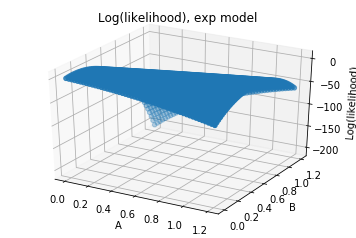

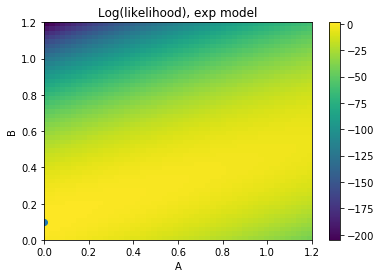

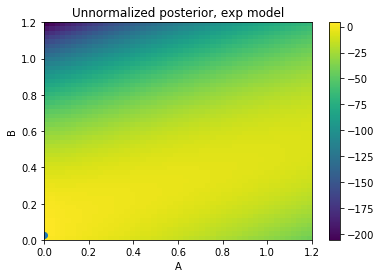

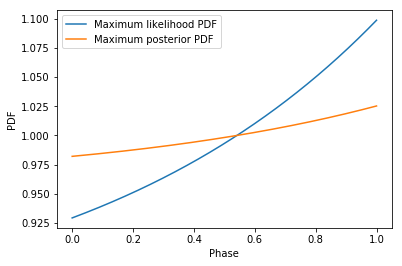

In [10]:
# Model PDF #3

def expmodel(x,A,B):
    C = 1-B*(exp(1)-1)-A*(exp(1)-1)/exp(1)
    return A*exp(-x)+B*exp(x)+C

Amin = 0.001
Amax = 1.2 # had to use this small range, otherwise ran into trouble with the log function
size = 50
Avec = linspace(Amin,Amax,size)
Bvec = Avec

# Define priors. Used identical Jeffreys priors for both parameters.
priorA = zeros(size)
priorA[1:] = 1./(Avec[1:]*log(Amax/Amin))
priorA[0] = priorA[1]
priorB = priorA

# Calculate log(priors)
papbvec = []
for pa in priorA:
    for pb in priorB:
        papbvec.append(log(pa)+log(pb))

# Calculate log(likelihood)
abvec = []
for a in Avec:
    for b in Bvec:
        abvec.append([a,b])

Avec = []
Bvec = []
likelihood = []
for n in abvec:
    a = n[0]
    b = n[1]
    probabilities = []
    for phi in phases_all:
        prob = expmodel(phi, a, b)+1e-10
        probabilities.append(prob)
    likepoint = sum(log(asarray(probabilities)))
    likelihood.append(likepoint)
    Avec.append(a)
    Bvec.append(b)

Avec = asarray(Avec)
Bvec = asarray(Bvec)
likelihood = asarray(likelihood)
m = likelihood.argmax()
best = [Avec[m], Bvec[m], likelihood[m]] # maximum likelihood
print("Location and maximum value of likelihood: " + str(best))
extent = (Avec.min(), Avec.max(), Bvec.min(), Bvec.max())

# Log(likelihood) plots
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(Avec,Bvec,likelihood)
ax.set_xlabel("A")
ax.set_ylabel("B")
ax.set_zlabel("Log(likelihood)")
ax.set_title("Log(likelihood), exp model")

likelihood2 = asarray(likelihood).reshape(size,size)
plt.figure()
plt.imshow(likelihood2.T, aspect='auto', origin='lower', extent=extent)
plt.colorbar()
plt.xlabel("A")
plt.ylabel("B")
plt.plot(Avec[m],Bvec[m], 'o')
plt.title("Log(likelihood), exp model")

# Unnormalized posterior plot
posterior = asarray(papbvec + likelihood)
mp = posterior.argmax()
bestp = [Avec[mp], Bvec[mp], posterior[mp]]
print("Location and maximum value of Posterior PDF: " + str(bestp))
plt.figure()
plt.imshow(posterior.reshape(size,size).T, aspect='auto', origin='lower', extent=extent)
plt.plot(Avec[mp],Bvec[mp], 'o')
plt.colorbar()
plt.xlabel("A")
plt.ylabel("B")
plt.title("Unnormalized posterior, exp model")

# Find global likelihood
glikelihood3 = 0
for l in posterior:
    glikelihood3 = glikelihood3 + exp(l)
print("Global likelihood = " + str(glikelihood3))

# Plot PDF with maximum likelihood and maximum posterior parameters
xvec = linspace(0,1,1000)
a1, a2 = best[0], bestp[0]
b1, b2 = best[1], bestp[1]
lexp = []
pexp = []
for x in xvec:
    lexp.append(expmodel(x,a1,b1))
    pexp.append(expmodel(x,a2,b2))
plt.figure()
plt.plot(xvec, lexp, label = "Maximum likelihood PDF")
plt.plot(xvec, pexp, label = "Maximum posterior PDF")
plt.xlabel("Phase")
plt.ylabel("PDF")
plt.legend()
plt.show()

The maximum likelihood PDF and the maximum posterior PDF differ in this case, largely due to the nature of the priors. I ran the same simulation using flat priors and in that case both the maximum likelihood PDF and the maximum posterior PDF have the same parameters. This gives an idea of how the choice of priors can affect the results.

Overall, it looks like the best hypothesis is the sinusoid one, because it gives a larger value for the global likelihood. However, the largest value for the maximum likelihood is given by the beta distribution. The exponential distribution gives a larger global likelihood than the beta but less than the sinusoid model, and its maximum likelihood is the smallest of the three. This can be explained because of the different parameter range used; the larger the range, the smaller the Occam factor for the distribution, and the smaller the global likelihood will be, so the large parameter range used for the beta distribution decreases its global likelihood with respect to the other hypotheses even though it has the largest value for the maximum likelihood. We conclude that different parameter range choices and different choices of priors can dramatically affect the results of Bayesian analysis.